In [27]:
#!pip install glob2
!wget https://storage.googleapis.com/download.tensorflow.org/models/tflite/gpu/multi_person_mobilenet_v1_075_float.tflite

--2019-05-28 13:52:52--  https://storage.googleapis.com/download.tensorflow.org/models/tflite/gpu/multi_person_mobilenet_v1_075_float.tflite
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4002:802::2010, 216.58.196.208
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4002:802::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5048148 (4.8M) [application/octet-stream]
Saving to: ‘multi_person_mobilenet_v1_075_float.tflite.9’

multi_person_mobile 100%[===================>]   4.81M  41.4KB/s    in 30s     

2019-05-28 13:53:23 (165 KB/s) - ‘multi_person_mobilenet_v1_075_float.tflite.9’ saved [5048148/5048148]



In [28]:
import glob2
import os
from random import randint
from IPython.core.display import Image, display
import numpy as np
import numpy as np
import tensorflow as tf
from skimage import transform,io
#import PIL
#from PIL import Image

In [29]:
training_path = "/home/prajwal/Pictures"
glob_search_path = os.path.join(training_path, "baseball.jpg")
jpg_paths = glob2.glob(glob_search_path)
print("jpg_paths", len(jpg_paths))

jpg_paths 1


In [30]:
index = randint(0,len(jpg_paths)-1)
img_filename = jpg_paths[index]
print("File %s: %s" % (index, img_filename))
#display(Image(filename=img_filename, width=257, height=353))

File 0: /home/prajwal/Pictures/baseball.jpg


In [31]:
image = io.imread(img_filename)
print(image.shape)
image_rot = transform.rotate(image,90.0,resize=True)
print(image_rot.shape)
small_input = transform.resize(image_rot,(353,257), mode='symmetric', preserve_range=True)
# reshape to (1,784)

reshape_img = small_input.reshape(1, 353,257, 3)
print(reshape_img.shape)

(513, 513, 3)
(513, 513, 3)
(1, 353, 257, 3)


/home/prajwal/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [32]:
PART_NAMES = [
    "nose", "leftEye", "rightEye", "leftEar", "rightEar", "leftShoulder",
    "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
    "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"
]

NUM_KEYPOINTS = len(PART_NAMES)

PART_IDS = {pn: pid for pid, pn in enumerate(PART_NAMES)}

CONNECTED_PART_NAMES = [
    ("leftHip", "leftShoulder"), ("leftElbow", "leftShoulder"),
    ("leftElbow", "leftWrist"), ("leftHip", "leftKnee"),
    ("leftKnee", "leftAnkle"), ("rightHip", "rightShoulder"),
    ("rightElbow", "rightShoulder"), ("rightElbow", "rightWrist"),
    ("rightHip", "rightKnee"), ("rightKnee", "rightAnkle"),
    ("leftShoulder", "rightShoulder"), ("leftHip", "rightHip")
]

CONNECTED_PART_INDICES = [(PART_IDS[a], PART_IDS[b]) for a, b in CONNECTED_PART_NAMES]

LOCAL_MAXIMUM_RADIUS = 1

POSE_CHAIN = [
    ("nose", "leftEye"), ("leftEye", "leftEar"), ("nose", "rightEye"),
    ("rightEye", "rightEar"), ("nose", "leftShoulder"),
    ("leftShoulder", "leftElbow"), ("leftElbow", "leftWrist"),
    ("leftShoulder", "leftHip"), ("leftHip", "leftKnee"),
    ("leftKnee", "leftAnkle"), ("nose", "rightShoulder"),
    ("rightShoulder", "rightElbow"), ("rightElbow", "rightWrist"),
    ("rightShoulder", "rightHip"), ("rightHip", "rightKnee"),
    ("rightKnee", "rightAnkle")
]

PARENT_CHILD_TUPLES = [(PART_IDS[parent], PART_IDS[child]) for parent, child in POSE_CHAIN]

PART_CHANNELS = [
  'left_face',
  'right_face',
  'right_upper_leg_front',
  'right_lower_leg_back',
  'right_upper_leg_back',
  'left_lower_leg_front',
  'left_upper_leg_front',
  'left_upper_leg_back',
  'left_lower_leg_back',
  'right_feet',
  'right_lower_leg_front',
  'left_feet',
  'torso_front',
  'torso_back',
  'right_upper_arm_front',
  'right_upper_arm_back',
  'right_lower_arm_back',
  'left_lower_arm_front',
  'left_upper_arm_front',
  'left_upper_arm_back',
  'left_lower_arm_back',
  'right_hand',
  'right_lower_arm_front',
  'left_hand'
]

In [33]:
def traverse_to_targ_keypoint(
        edge_id, source_keypoint, target_keypoint_id, scores, offsets, output_stride, displacements
):
    height = scores.shape[0]
    width = scores.shape[1]

    source_keypoint_indices = np.clip(
        np.round(source_keypoint / output_stride), a_min=0, a_max=[height - 1, width - 1]).astype(np.int32)

    displaced_point = source_keypoint + displacements[
        source_keypoint_indices[0], source_keypoint_indices[1], edge_id]

    displaced_point_indices = np.clip(
        np.round(displaced_point / output_stride), a_min=0, a_max=[height - 1, width - 1]).astype(np.int32)

    score = scores[displaced_point_indices[0], displaced_point_indices[1], target_keypoint_id]

    image_coord = displaced_point_indices * output_stride + offsets[
        displaced_point_indices[0], displaced_point_indices[1], target_keypoint_id]

    return score, image_coord


def decode_pose(
        root_score, root_id, root_image_coord,
        scores,
        offsets,
        output_stride,
        displacements_fwd,
        displacements_bwd
):
    num_parts = scores.shape[2]
    num_edges = len(PARENT_CHILD_TUPLES)

    instance_keypoint_scores = np.zeros(num_parts)
    instance_keypoint_coords = np.zeros((num_parts, 2))
    instance_keypoint_scores[root_id] = root_score
    instance_keypoint_coords[root_id] = root_image_coord

    for edge in reversed(range(num_edges)):
        target_keypoint_id, source_keypoint_id = PARENT_CHILD_TUPLES[edge]
        if (instance_keypoint_scores[source_keypoint_id] > 0.0 and
                instance_keypoint_scores[target_keypoint_id] == 0.0):
            score, coords = traverse_to_targ_keypoint(
                edge,
                instance_keypoint_coords[source_keypoint_id],
                target_keypoint_id,
                scores, offsets, output_stride, displacements_bwd)
            instance_keypoint_scores[target_keypoint_id] = score
            instance_keypoint_coords[target_keypoint_id] = coords

    for edge in range(num_edges):
        source_keypoint_id, target_keypoint_id = PARENT_CHILD_TUPLES[edge]
        if (instance_keypoint_scores[source_keypoint_id] > 0.0 and
                instance_keypoint_scores[target_keypoint_id] == 0.0):
            score, coords = traverse_to_targ_keypoint(
                edge,
                instance_keypoint_coords[source_keypoint_id],
                target_keypoint_id,
                scores, offsets, output_stride, displacements_fwd)
            instance_keypoint_scores[target_keypoint_id] = score
            instance_keypoint_coords[target_keypoint_id] = coords

    return instance_keypoint_scores, instance_keypoint_coords


## def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [34]:
import time
import scipy.ndimage as ndi


def within_nms_radius(poses, squared_nms_radius, point, keypoint_id):
    for _, _, pose_coord in poses:
        if np.sum((pose_coord[keypoint_id] - point) ** 2) <= squared_nms_radius:
            return True
    return False


def within_nms_radius_fast(pose_coords, squared_nms_radius, point):
    if not pose_coords.shape[0]:
        return False
    return np.any(np.sum((pose_coords - point) ** 2, axis=1) <= squared_nms_radius)


def get_instance_score(
        existing_poses, squared_nms_radius,
        keypoint_scores, keypoint_coords):
    not_overlapped_scores = 0.
    for keypoint_id in range(len(keypoint_scores)):
        if not within_nms_radius(
                existing_poses, squared_nms_radius,
                keypoint_coords[keypoint_id], keypoint_id):
            not_overlapped_scores += keypoint_scores[keypoint_id]
    return not_overlapped_scores / len(keypoint_scores)


def get_instance_score_fast(
        exist_pose_coords,
        squared_nms_radius,
        keypoint_scores, keypoint_coords):

    if exist_pose_coords.shape[0]:
        s = np.sum((exist_pose_coords - keypoint_coords) ** 2, axis=2) > squared_nms_radius
        not_overlapped_scores = np.sum(keypoint_scores[np.all(s, axis=0)])
    else:
        not_overlapped_scores = np.sum(keypoint_scores)
    return not_overlapped_scores / len(keypoint_scores)


def score_is_max_in_local_window(keypoint_id, score, hmy, hmx, local_max_radius, scores):
    height = scores.shape[0]
    width = scores.shape[1]

    y_start = max(hmy - local_max_radius, 0)
    y_end = min(hmy + local_max_radius + 1, height)
    x_start = max(hmx - local_max_radius, 0)
    x_end = min(hmx + local_max_radius + 1, width)

    for y in range(y_start, y_end):
        for x in range(x_start, x_end):
            if scores[y, x, keypoint_id] > score:
                return False
    return True


def build_part_with_score(score_threshold, local_max_radius, scores):
    parts = []
    height = scores.shape[0]
    width = scores.shape[1]
    num_keypoints = scores.shape[2]

    for hmy in range(height):
        for hmx in range(width):
            for keypoint_id in range(num_keypoints):
                score = scores[hmy, hmx, keypoint_id]
                if score < score_threshold:
                    continue
                if score_is_max_in_local_window(keypoint_id, score, hmy, hmx,
                                                local_max_radius, scores):
                    parts.append((
                        score, keypoint_id, np.array((hmy, hmx))
                    ))
    return parts


def build_part_with_score_fast(score_threshold, local_max_radius, scores):
    parts = []
    num_keypoints = scores.shape[2]
    lmd = 2 * local_max_radius + 1

    # NOTE it seems faster to iterate over the keypoints and perform maximum_filter
    # on each subarray vs doing the op on the full score array with size=(lmd, lmd, 1)
    for keypoint_id in range(num_keypoints):
        kp_scores = scores[:, :, keypoint_id].copy()
        kp_scores[kp_scores < score_threshold] = 0.
        max_vals = ndi.maximum_filter(kp_scores, size=lmd, mode='constant')
        max_loc = np.logical_and(kp_scores == max_vals, kp_scores > 0)
        max_loc_idx = max_loc.nonzero()
        for y, x in zip(*max_loc_idx):
            parts.append((
                scores[y, x, keypoint_id],
                keypoint_id,
                np.array((y, x))
            ))

    return parts


def decode_multiple_poses(
        scores, offsets, displacements_fwd, displacements_bwd, output_stride,
        max_pose_detections=10, score_threshold=0.5, nms_radius=20, min_pose_score=0.5):

    pose_count = 0
    pose_scores = np.zeros(max_pose_detections)
    pose_keypoint_scores = np.zeros((max_pose_detections, NUM_KEYPOINTS))
    pose_keypoint_coords = np.zeros((max_pose_detections, NUM_KEYPOINTS, 2))

    squared_nms_radius = nms_radius ** 2

    scored_parts = build_part_with_score_fast(score_threshold, LOCAL_MAXIMUM_RADIUS, scores)
    scored_parts = sorted(scored_parts, key=lambda x: x[0], reverse=True)

    # change dimensions from (h, w, x) to (h, w, x//2, 2) to allow return of complete coord array
    height = scores.shape[0]
    width = scores.shape[1]
    offsets = offsets.reshape(height, width, 2, -1).swapaxes(2, 3)
    displacements_fwd = displacements_fwd.reshape(height, width, 2, -1).swapaxes(2, 3)
    #displacements_bwd = displacements_bwd.reshape(height, width, 2, -1).swapaxes(2, 3)

    for root_score, root_id, root_coord in scored_parts:
        root_image_coords = root_coord * output_stride + offsets[
            root_coord[0], root_coord[1], root_id]

        if within_nms_radius_fast(
                pose_keypoint_coords[:pose_count, root_id, :], squared_nms_radius, root_image_coords):
            continue

        keypoint_scores, keypoint_coords = decode_pose(
            root_score, root_id, root_image_coords,
            scores, offsets, output_stride,
            displacements_fwd, displacements_bwd)

        pose_score = get_instance_score_fast(
            pose_keypoint_coords[:pose_count, :, :], squared_nms_radius, keypoint_scores, keypoint_coords)

        # NOTE this isn't in the original implementation, but it appears that by initially ordering by
        # part scores, and having a max # of detections, we can end up populating the returned poses with
        # lower scored poses than if we discard 'bad' ones and continue (higher pose scores can still come later).
        # Set min_pose_score to 0. to revert to original behaviour
        if min_pose_score == 0. or pose_score >= min_pose_score:
            pose_scores[pose_count] = pose_score
            pose_keypoint_scores[pose_count, :] = keypoint_scores
            pose_keypoint_coords[pose_count, :, :] = keypoint_coords
            pose_count += 1

        if pose_count >= max_pose_detections:
            break

    return pose_scores, pose_keypoint_scores, pose_keypoint_coords


In [35]:
MODEL_DIR = './_models'

def model_id_to_ord(model_id):
    if 0 <= model_id < 4:
        return model_id  # id is already ordinal
    elif model_id == 50:
        return 0
    elif model_id == 75:
        return 1
    elif model_id == 100:
        return 2
    else:  # 101
        return 3


def load_config(model_ord):
    converter_cfg = posenet.converter.config.load_config()
    checkpoints = converter_cfg['checkpoints']
    output_stride = converter_cfg['outputStride']
    checkpoint_name = checkpoints[model_ord]

    model_cfg = {
        'output_stride': output_stride,
        'checkpoint_name': checkpoint_name,
    }
    return model_cfg


def load_model(model_id, sess, model_dir=MODEL_DIR):
    model_ord = model_id_to_ord(model_id)
    model_cfg = load_config(model_ord)
    model_path = os.path.join(model_dir, 'model-%s.pb' % model_cfg['checkpoint_name'])
    if not os.path.exists(model_path):
        print('Cannot find model file %s, converting from tfjs...' % model_path)
        from posenet.converter.tfjs2python import convert
        convert(model_ord, model_dir, check=False)
        assert os.path.exists(model_path)

    with tf.gfile.GFile(model_path, 'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

    if DEBUG_OUTPUT:
        graph_nodes = [n for n in graph_def.node]
        names = []
        for t in graph_nodes:
            names.append(t.name)
            print('Loaded graph node:', t.name)

    offsets = sess.graph.get_tensor_by_name('offset_2:0')
    displacement_fwd = sess.graph.get_tensor_by_name('displacement_fwd_2:0')
    displacement_bwd = sess.graph.get_tensor_by_name('displacement_bwd_2:0')
    heatmaps = sess.graph.get_tensor_by_name('heatmap:0')

    return model_cfg, [heatmaps, offsets, displacement_fwd, displacement_bwd]


In [36]:
def valid_resolution(width, height, output_stride=16):
    target_width = (int(width) // output_stride) * output_stride + 1
    target_height = (int(height) // output_stride) * output_stride + 1
    return target_width, target_height


def _process_input(source_img, scale_factor=1.0, output_stride=16):
    target_width, target_height = valid_resolution(
        source_img.shape[1] * scale_factor, source_img.shape[0] * scale_factor, output_stride=output_stride)
    scale = np.array([source_img.shape[0] / target_height, source_img.shape[1] / target_width])

    input_img = cv2.resize(source_img, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB).astype(np.float32)
    input_img = input_img * (2.0 / 255.0) - 1.0
    input_img = input_img.reshape(1, target_height, target_width, 3)
    return input_img, source_img, scale


def read_cap(cap, scale_factor=1.0, output_stride=16):
    res, img = cap.read()
    if not res:
        raise IOError("webcam failure")
    return _process_input(img, scale_factor, output_stride)


def read_imgfile(path, scale_factor=1.0, output_stride=16):
    img = cv2.imread(path)
    return _process_input(img, scale_factor, output_stride)


def draw_keypoints(
        img, instance_scores, keypoint_scores, keypoint_coords,
        min_pose_confidence=0.5, min_part_confidence=0.5):
    cv_keypoints = []
    for ii, score in enumerate(instance_scores):
        if score < min_pose_confidence:
            continue
        for ks, kc in zip(keypoint_scores[ii, :], keypoint_coords[ii, :, :]):
            if ks < min_part_confidence:
                continue
            cv_keypoints.append(cv2.KeyPoint(kc[1], kc[0], 10. * ks))
    out_img = cv2.drawKeypoints(img, cv_keypoints, outImage=np.array([]))
    return out_img


def get_adjacent_keypoints(keypoint_scores, keypoint_coords, min_confidence=0.1):
    results = []
    for left, right in posenet.CONNECTED_PART_INDICES:
        if keypoint_scores[left] < min_confidence or keypoint_scores[right] < min_confidence:
            continue
        results.append(
            np.array([keypoint_coords[left][::-1], keypoint_coords[right][::-1]]).astype(np.int32),
        )
    return results


def draw_skeleton(
        img, instance_scores, keypoint_scores, keypoint_coords,
        min_pose_confidence=0.5, min_part_confidence=0.5):
    out_img = img
    adjacent_keypoints = []
    for ii, score in enumerate(instance_scores):
        if score < min_pose_confidence:
            continue
        new_keypoints = get_adjacent_keypoints(
            keypoint_scores[ii, :], keypoint_coords[ii, :, :], min_part_confidence)
        adjacent_keypoints.extend(new_keypoints)
    out_img = cv2.polylines(out_img, adjacent_keypoints, isClosed=False, color=(255, 255, 0))
    return out_img


def draw_skel_and_kp(
        img, instance_scores, keypoint_scores, keypoint_coords,
        min_pose_score=0.5, min_part_score=0.5):
    out_img = img
    adjacent_keypoints = []
    cv_keypoints = []
    for ii, score in enumerate(instance_scores):
        if score < min_pose_score:
            continue

        new_keypoints = get_adjacent_keypoints(
            keypoint_scores[ii, :], keypoint_coords[ii, :, :], min_part_score)
        adjacent_keypoints.extend(new_keypoints)

        for ks, kc in zip(keypoint_scores[ii, :], keypoint_coords[ii, :, :]):
            if ks < min_part_score:
                continue
            cv_keypoints.append(cv2.KeyPoint(kc[1], kc[0], 10. * ks))

    out_img = cv2.drawKeypoints(
        out_img, cv_keypoints, outImage=np.array([]), color=(255, 255, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    out_img = cv2.polylines(out_img, adjacent_keypoints, isClosed=False, color=(255, 255, 0))
    return out_img


In [40]:
import cv2

def main():

    interpreter = tf.contrib.lite.Interpreter(model_path="./multi_person_mobilenet_v1_075_float.tflite")
    interpreter.allocate_tensors()

    # Get input and output tensors.
    model_cfg = interpreter.get_input_details()
    model_output = interpreter.get_output_details()
    model_outputs = interpreter.get_tensor(model_output[0]['index'])

    output_path='/home/prajwal/Pictures/output';

    if output_path:
        if not os.path.exists(output_path):
            os.makedirs(output_path)

    filenames = [
        f.path for f in os.scandir(training_path) if f.is_file() and f.path.endswith(('.png', '.jpg'))]

    start = time.time()
    for f in filenames:
        print(f)
            
        input_image, draw_image, output_scale = read_imgfile(
            f, scale_factor=1, output_stride=16)

        heatmaps_result,offsets_result, displacement_fwd_result, displacement_bwd_result= (
            interpreter.get_tensor(model_output[0]['index']),interpreter.get_tensor(model_output[1]['index']),
            interpreter.get_tensor(model_output[2]['index']),interpreter.get_tensor(model_output[3]['index'])
                
        )
           
            
            
            
        print(heatmaps_result.squeeze(axis=0))
          
        

main()


/home/prajwal/Pictures/baseball.jpg
[[[ 1.0763510e+35  3.0652003e-41  2.1474982e-27 ...  1.1955673e+30
    1.7612745e+00 -7.3128267e+12]
  [ 1.7877450e+00  1.5365198e+16  1.7058823e+00 ...  1.7137254e+00
   -9.2500566e-28  1.7700980e+00]
  [ 2.7151725e-06  1.7985294e+00  4.6092140e-28 ...  3.6477857e+12
    1.6588235e+00 -1.9074022e+15]
  ...
  [-4.9733828e+17  1.7254901e+00 -4.5273976e+11 ...  3.6477914e+12
    1.6588235e+00 -4.7464415e+14]
  [ 1.6862744e+00  4.0058359e+18  1.7372549e+00 ...  1.7553921e+00
    1.1443778e-28  1.6333333e+00]
  [ 2.3677032e+14  1.6823529e+00 -8.0297703e+18 ...  1.7664209e-04
    1.8220588e+00  7.4760232e-27]]

 [[ 1.7818627e+00  1.5365178e+16  1.8308823e+00 ...  1.8455882e+00
   -6.7603190e-20  1.8720587e+00]
  [-1.5525988e+32  1.7887254e+00 -5.7291687e-03 ...  1.2123926e-25
    1.7975490e+00 -4.0398222e+34]
  [ 1.8200979e+00  2.3677140e+14  1.6823529e+00 ...  1.6784313e+00
   -3.9445183e-24  1.6921568e+00]
  ...
  [ 1.6063725e+00  5.1653456e-22  1.46960

In [38]:

import PIL.Image
#from cStringIO import StringIO
import io
import IPython.display
import numpy as np
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = io.StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

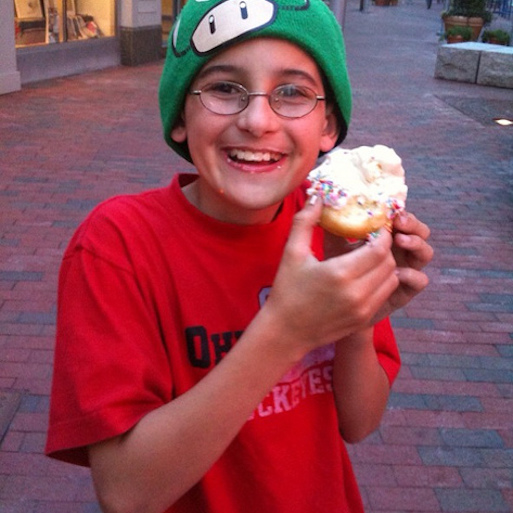

In [39]:
PIL.Image.fromarray(image)

In [14]:

imshow(small_input)
imshow(image_rot)
imshow(image)

NameError: name 'imshow' is not defined

In [ ]:
import posenet